<h3 style="text-align: center">⚠️⚠️⚠️⚠️⚠️⚠️⚠️⚠️⚠️⚠️⚠️⚠️⚠️⚠️⚠️⚠️⚠️⚠️⚠️⚠️⚠️</h3>
<h3 style="text-align: center"><u>Deprecated</u></h3>
<h3 style="text-align: center">El problema de lilith01-02 ha sido la ineficencia de recogida de datos y los problemas generados por entrenar en versiones antiguas de Tensorflow</h3>
<h3 style="text-align: center">⚠️⚠️⚠️⚠️⚠️⚠️⚠️⚠️⚠️⚠️⚠️⚠️⚠️⚠️⚠️⚠️⚠️⚠️⚠️⚠️⚠️⚠️</h3>


0.0 CARGA DE BIBLIOTECAS, VARIABLES, CLASES Y MÉTODOS IMPORTANTES

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import json
from tensorflow.keras.preprocessing.text import Tokenizer
import pickle
import numpy as np

archivo_json = '../../Chessia_Data_Convert/Target Data/Datos-JSON.json'
tokenizer_file = "tokenizer.pkl"

class Partida:
    def __init__(self):
        self.movimientos = []
        self.resultado = None

# Función para cargar partidas en lotes
def cargar_partidas_por_lotes(archivo_json, tam_lote=1000):
    total_movimientos = []
    total_resultados = []
    with open(archivo_json, 'r') as file:
        # Carga el contenido completo como una lista de objetos JSON
        lista_json = json.load(file)
        
        # Itera sobre cada objeto JSON en la lista
        for partida_json in lista_json:
            total_movimientos.append(partida_json['partida']['movimientos'])
            total_resultados.append(partida_json['partida']['resultado'])
            
            if len(total_movimientos) == tam_lote:
                yield total_movimientos, total_resultados
                total_movimientos = []
                total_resultados = []

    # Devuelve el último lote si no se ha alcanzado el tamaño del lote
    if total_movimientos:
        yield total_movimientos, total_resultados
        

1.0 PROCESADO DE DATOS DE LILITH01 - USA ProcesadorPGN_V1
    
    (no tiene sentido, uso los mismos datos para validar que para entrenar)

In [5]:
# Convertir el generador en una lista y extraer la primera tupla
recogido = next(cargar_partidas_por_lotes(archivo_json, tam_lote=70000))
movimientos = recogido[0]
resultados = recogido[1]

# Crear y ajustar el tokenizador
tokenizer = Tokenizer()
tokenizer.fit_on_texts(movimientos)

# Convertir las jugadas a secuencias de números enteros
movimientos_secuencias_entrenamiento = tokenizer.texts_to_sequences(movimientos)
resultados = [int(resultado) for resultado in resultados]
resultados_numericos_entrenamiento = tf.one_hot(resultados, depth=3)  # 3 clases: empate, victoria blanca, victoria negra

recogido = next(cargar_partidas_por_lotes(archivo_json, tam_lote=30000))
movimientos = recogido[0]
resultados = recogido[1]

# Convertir las jugadas de prueba a secuencias de números enteros usando el mismo tokenizador
movimientos_secuencias_prueba = tokenizer.texts_to_sequences(movimientos)
resultados = [int(resultado) for resultado in resultados]
resultados_numericos_prueba = tf.one_hot(resultados, depth=3)  # 3 clases: empate, victoria blanca, victoria negra

# Convertir las listas de listas de enteros en tensores de TensorFlow
movimientos_numericos_entrenamiento = tf.constant(movimientos_secuencias_entrenamiento)
resultados_numericos_entrenamiento = tf.constant(resultados_numericos_entrenamiento)

movimientos_numericos_prueba = tf.constant(movimientos_secuencias_prueba)
resultados_numericos_prueba = tf.constant(resultados_numericos_prueba)



1.1 LILITH 01 - DEFINICIÓN Y ENTRENAMIENTO

In [42]:
# 1. Definir el modelo
modelo = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=100, input_length=500),
    tf.keras.layers.LSTM(units=64),
    tf.keras.layers.Dense(units=3, activation='softmax')
])

# 2. Compilar el modelo
modelo.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Entrenar el modelo y guardar el historial del entrenamiento
historial_entrenamiento = modelo.fit(
    movimientos_numericos_entrenamiento,
    resultados_numericos_entrenamiento,
    epochs=15,
    batch_size=64,
    validation_data=(movimientos_numericos_prueba, resultados_numericos_prueba)  # Datos de validación
)

modelo.save("modelos/lilith01.h5")

# 4. Evaluar el modelo
test_loss, test_accuracy = modelo.evaluate(movimientos_numericos_prueba, resultados_numericos_prueba)
print("Loss en los datos de prueba:", test_loss)
print("Precisión en los datos de prueba:", test_accuracy)

Epoch 1/15
1094/1094 [==============================] - 302s 274ms/step - loss: 0.8800 - accuracy: 0.5894 - val_loss: 0.7847 - val_accuracy: 0.6592
Epoch 2/15
1094/1094 [==============================] - 289s 264ms/step - loss: 0.7471 - accuracy: 0.6745 - val_loss: 0.6003 - val_accuracy: 0.7480
Epoch 3/15
1094/1094 [==============================] - 290s 265ms/step - loss: 0.5648 - accuracy: 0.7634 - val_loss: 0.4856 - val_accuracy: 0.8035
Epoch 4/15
1094/1094 [==============================] - 315s 288ms/step - loss: 0.5152 - accuracy: 0.7881 - val_loss: 0.4431 - val_accuracy: 0.8266
Epoch 5/15
1094/1094 [==============================] - 323s 295ms/step - loss: 0.4723 - accuracy: 0.8088 - val_loss: 0.4196 - val_accuracy: 0.8338
Epoch 6/15
1094/1094 [==============================] - 291s 266ms/step - loss: 0.4381 - accuracy: 0.8261 - val_loss: 0.3623 - val_accuracy: 0.8640
Epoch 7/15
1094/1094 [==============================] - 300s 274ms/step - loss: 0.4074 - accuracy: 0.8402 - val_

c:\Users\arube\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


938/938 [==============================] - 76s 81ms/step - loss: 0.1216 - accuracy: 0.9621
Loss en los datos de prueba: 0.1215505376458168
Precisión en los datos de prueba: 0.962066650390625


1.2 LILITH 01 - GRÁFICAS DE ENTRENAMIENTO

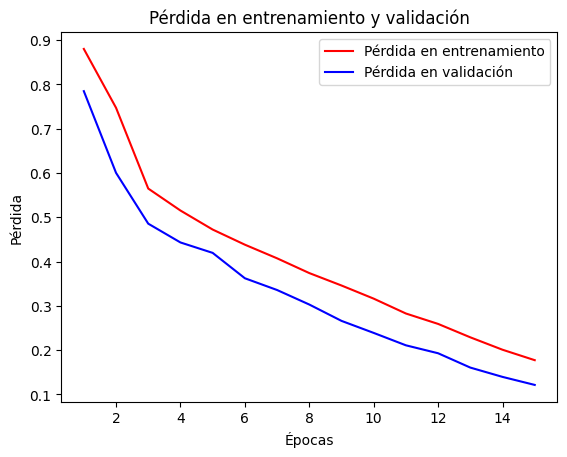

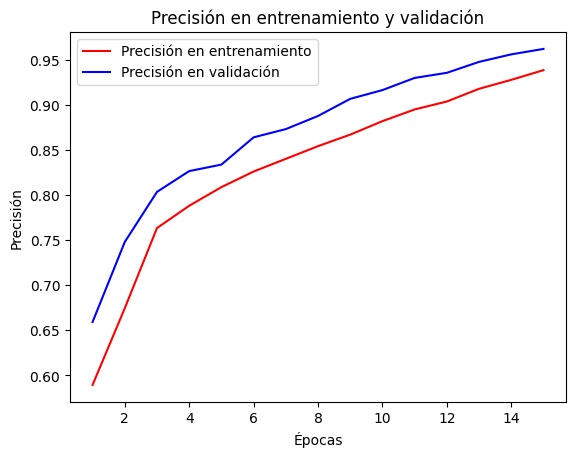

In [43]:
# Obtener la pérdida y la precisión del entrenamiento y de la validación
pérdida_entrenamiento = historial_entrenamiento.history['loss']
precisión_entrenamiento = historial_entrenamiento.history['accuracy']
pérdida_validación = historial_entrenamiento.history['val_loss']  # Modificado para usar los datos de validación
precisión_validación = historial_entrenamiento.history['val_accuracy']  # Modificado para usar los datos de validación
épocas = range(1, len(pérdida_entrenamiento) + 1)

# Graficar la pérdida
plt.plot(épocas, pérdida_entrenamiento, 'r', label='Pérdida en entrenamiento')
plt.plot(épocas, pérdida_validación, 'b', label='Pérdida en validación')
plt.title('Pérdida en entrenamiento y validación')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.show()

# Graficar la precisión
plt.plot(épocas, precisión_entrenamiento, 'r', label='Precisión en entrenamiento')
plt.plot(épocas, precisión_validación, 'b', label='Precisión en validación')
plt.title('Precisión en entrenamiento y validación')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()
plt.show()

1.3 PRUEBA DE PREDICCIÓN

    (sin sentido, uso las primeras partidas con las que entrené y nuevos tokens)

In [38]:
import numpy as np
np.set_printoptions(suppress=True, precision=4)

lilith01 = tf.keras.models.load_model("modelos/lilith01.h5")

# Convertir el generador en una lista y extraer la primera tupla
recogido = next(cargar_partidas_por_lotes(archivo_json, tam_lote=5))
movimientos = recogido[0]
resultados = recogido[1]

# Crear y ajustar el tokenizador
tokenizer = Tokenizer()
tokenizer.fit_on_texts(movimientos)

# Convertir las jugadas a secuencias de números enteros
movimientos_secuencias_predict = tokenizer.texts_to_sequences(movimientos)

movimientos_prueba = []
for i in range(len(movimientos_secuencias_predict[0])):
    if movimientos_secuencias_predict[0][i] != 1:
        movimientos_prueba.append(movimientos_secuencias_predict[0][i])

resultados_predichos = lilith01.predict(movimientos_secuencias_predict)
print(resultados_predichos)
print(resultados)

1/1 [==============================] - 1s 659ms/step
[[0.0062 0.0069 0.987 ]
 [0.0001 0.0002 0.9998]
 [0.0767 0.5139 0.4094]
 [0.141  0.2569 0.602 ]
 [0.6777 0.1697 0.1525]]
['1', '1', '1', '0', '2']


2.0 PROCESADO DE DATOS DE LILITH02 - USA ProcesadorPGN_V1

    (arreglado el procesado de lotes de entrenamiento y validación y guardamos tokens que usamos)

In [42]:
# Convertir el generador en una lista y extraer la primera tupla
recogido = next(cargar_partidas_por_lotes(archivo_json, tam_lote=100000))
movimientos = recogido[0]
resultados = recogido[1]

# Crear y ajustar el tokenizador
tokenizer = Tokenizer()
tokenizer.fit_on_texts(movimientos)

# Guardar el tokenizador como un archivo JSON
# Guardar el objeto Tokenizer en un archivo usando pickle
with open(tokenizer_file, "wb") as f:
    pickle.dump(tokenizer, f)

# Convertir todas las jugadas a secuencias de números enteros
movimientos_secuencias = tokenizer.texts_to_sequences(movimientos)
resultados = [int(resultado) for resultado in resultados]
resultados_numericos = tf.one_hot(resultados, depth=3)  # 3 clases: empate, victoria blanca, victoria negra

# Dividir las secuencias de movimientos y resultados en datos de entrenamiento y prueba
# Convertir las listas de listas de enteros en tensores de TensorFlow
movimientos_numericos_entrenamiento = tf.constant(movimientos_secuencias[:70000])
resultados_numericos_entrenamiento = tf.constant(resultados_numericos[:70000])
movimientos_numericos_prueba = tf.constant(movimientos_secuencias[70000:])
resultados_numericos_prueba = tf.constant(resultados_numericos[70000:])

2.1 LILITH 02 - DEFINICIÓN, ENTRENAMIENTO Y GRÁFICAS DE DATOS

    (las gráficas marcan que es una mierda de validación, acierta más algo aleatorio)

Epoch 1/18
730/730 [==============================] - 1164s 2s/step - loss: 0.8856 - accuracy: 0.5878 - val_loss: 0.8259 - val_accuracy: 0.6288
Epoch 2/18
730/730 [==============================] - 1168s 2s/step - loss: 0.8017 - accuracy: 0.6456 - val_loss: 0.7938 - val_accuracy: 0.6514
Epoch 3/18
730/730 [==============================] - 1164s 2s/step - loss: 0.7424 - accuracy: 0.6792 - val_loss: 0.6881 - val_accuracy: 0.7084
Epoch 4/18
730/730 [==============================] - 1083s 1s/step - loss: 0.5612 - accuracy: 0.7648 - val_loss: 0.5670 - val_accuracy: 0.7646
Epoch 5/18
730/730 [==============================] - 1099s 2s/step - loss: 0.5059 - accuracy: 0.7916 - val_loss: 0.5506 - val_accuracy: 0.7716
Epoch 6/18
730/730 [==============================] - 1092s 1s/step - loss: 0.4714 - accuracy: 0.8100 - val_loss: 0.5591 - val_accuracy: 0.7702
Epoch 7/18
730/730 [==============================] - 1098s 2s/step - loss: 0.4358 - accuracy: 0.8259 - val_loss: 0.5540 - val_accuracy:

c:\Users\arube\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


938/938 [==============================] - 56s 60ms/step - loss: 0.9029 - accuracy: 0.7719
Loss en los datos de prueba: 0.9029188752174377
Precisión en los datos de prueba: 0.7718999981880188


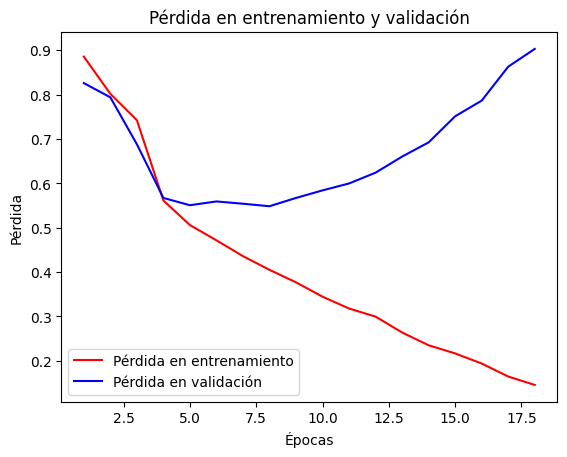

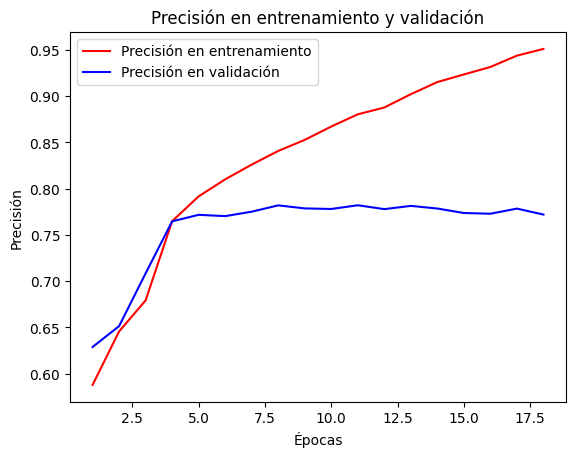

In [45]:
# 1. Definir el modelo
modelo2 = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=100, input_length=500),
    tf.keras.layers.LSTM(units=64),
    tf.keras.layers.Dense(units=3, activation='softmax')
])

# 2. Compilar el modelo
modelo2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Entrenar el modelo y guardar el historial del entrenamiento
historial_entrenamiento2 = modelo2.fit(
    movimientos_numericos_entrenamiento,
    resultados_numericos_entrenamiento,
    epochs=18,
    batch_size=96,
    validation_data=(movimientos_numericos_prueba, resultados_numericos_prueba)  # Datos de validación
)

modelo2.save("modelos/lilith02.h5")

# 4. Evaluar el modelo
test_loss, test_accuracy = modelo2.evaluate(movimientos_numericos_prueba, resultados_numericos_prueba)
print("Loss en los datos de prueba:", test_loss)
print("Precisión en los datos de prueba:", test_accuracy)

# Obtener la pérdida y la precisión del entrenamiento y de la validación
pérdida_entrenamiento = historial_entrenamiento2.history['loss']
precisión_entrenamiento = historial_entrenamiento2.history['accuracy']
pérdida_validación = historial_entrenamiento2.history['val_loss']  # Modificado para usar los datos de validación
precisión_validación = historial_entrenamiento2.history['val_accuracy']  # Modificado para usar los datos de validación
épocas = range(1, len(pérdida_entrenamiento) + 1)

# Graficar la pérdida
plt.plot(épocas, pérdida_entrenamiento, 'r', label='Pérdida en entrenamiento')
plt.plot(épocas, pérdida_validación, 'b', label='Pérdida en validación')
plt.title('Pérdida en entrenamiento y validación')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.show()

# Graficar la precisión
plt.plot(épocas, precisión_entrenamiento, 'r', label='Precisión en entrenamiento')
plt.plot(épocas, precisión_validación, 'b', label='Precisión en validación')
plt.title('Precisión en entrenamiento y validación')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()
plt.show()

2.2 PRUEBA DEPREDICCIÓN LILITH02

    (bastante mal, además los tokens no se recogen del fichero no sé por qué)

2.2.1 RECOGIDA DE DATOS Y TOKENS

In [13]:
# Convertir el generador en una lista y extraer la primera tupla
recogido = next(cargar_partidas_por_lotes(archivo_json, tam_lote=100070))
movimientos = recogido[0]
resultados = recogido[1]

# Como la carga desde el archo funciona mal, los vuelvo a generar y rezo para que sean iguales
# Crear y ajustar el tokenizador
nuevoTokenizer = Tokenizer()
nuevoTokenizer.fit_on_texts(movimientos[:100000])

movimientos = recogido[0][100040:]
resultados = recogido[1][100040:]


2.2.2 PREDICCIÓN Y MUESTRA DE DATOS

    (problemita de versiones, pero vamos, que tampoco predecía)

In [14]:
np.set_printoptions(suppress=True, precision=4)

lilith02 = tf.keras.models.load_model("modelos/lilith02.h5")

# Crear y ajustar el tokenizador
nuevoTokenizer.fit_on_texts(movimientos)

# Convertir las jugadas a secuencias de números enteros
movimientos_secuencias_predict = nuevoTokenizer.texts_to_sequences(movimientos)

movimientos_prueba = []
for i in range(len(movimientos_secuencias_predict[0])):
    if movimientos_secuencias_predict[0][i] != 1:
        movimientos_prueba.append(movimientos_secuencias_predict[0][i])

resultados_predichos = lilith02.predict(movimientos_secuencias_predict)

for i in range(len(resultados_predichos)):
    print(f"Predicción: {resultados_predichos[i]} -- Dice: {np.argmax(resultados_predichos[i])} -- Real: {resultados[i]}")

c:\Users\arube\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\embedding.py:86: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
c:\Users\arube\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\embedding.py:89: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


ValueError: Could not interpret initializer identifier: {'module': 'keras.initializers', 'class_name': 'Orthogonal', 'config': {'gain': 1.0, 'seed': None}, 'registered_name': None}